# Waste Classification

<div style="background-color: whitesmoke; padding: 30px; padding-top: 10px;">
    <h2>Table of Contents</h2>
    <div><a href="#S1">1. Introduction</a></div>
    <div><a href="#S2">2. Load and Inspect Data</a></div>
    <div><a href="#S3">3. Build Model</a></div>
    <div><a href="#S4">4. Train the Model</a></div>
    <div><a href="#S5">5. Fine-tune the Model</a></div>
    <div><a href="#S6">6. Model Prediction and Evaluation</a></div>
</div>

## <a id="S1"></a> 1. Introduction

The effective classification of waste is a critical challenge in modern waste management. Accurate sorting of waste at the source or at processing facilities is essential for maximising recycling efforts, reducing the volume of waste sent to landfill sites, and minimising environmental pollution. Inefficient waste classification leads to reduced recycling rates, increased contamination of recyclable materials, higher costs for waste processing, and greater environmental harm due to improper disposal.

Thus, the goal of this project is to leverage machine learning and computer vision to automate the classification of waste products, improving waste-sorting efficiency and reducing contamination levels, contributing to more sustainable waste management practices. Automated waste classification systems have the potential to significantly improve the speed and accuracy of sorting, reduce labour costs, and enable more effective resource recovery.

The project will use transfer learning with a pre-trained VGG16 model to classify images. VGG16 is a powerful convolutional neural network that has been shown to be highly effective in image recognition tasks. Transfer learning allows us to utilise the knowledge learned by VGG16 on a large dataset (ImageNet) to efficiently train our model, even with a relatively smaller waste classification dataset.

For this analysis, the [Waste Classification](https://www.kaggle.com/datasets/techsash/waste-classification-data/data) dataset available on Kaggle will be used. This dataset provides images of waste products categorised into 'Organic' and 'Recyclable' materials. Understanding the specific types of organic (e.g., food waste, garden waste) and recyclable (e.g., paper, plastic, metal) waste present in the dataset is important for interpreting the model's performance and its applicability to real-world waste management scenarios.

### Skills
- Preparation and preprocessing of image data for machine learning
- Image classification
- Transfer learning (VGG16 model)
- Fine-tuning of a pre-trained model
- Model training and evaluation
- Visualisation of model predictions

### Tools
- numpy
- seaborn
- matplotlib
- keras
  - augmentation (ImageDataGenerator)
  - pre-trained models (vgg16)
  - layers (Dense, Dropout, Flatten, BatchNormalization)
  - custom callbacks (EarlyStopping, ModelCheckpoint)
  - learning rate scheduling (LearningRateScheduler, ReduceLROnPlateau)
  - model evaluation (classification_report, confusion_matrix)
  
### Install and import libraries

In [1]:
# !pip -q install tensorflow
# !pip -q install numpy
# !pip -q install scikit-learn
# !pip -q install matplotlib

import numpy as np
import os
import glob
from pathlib import Path
import random
from PIL import Image

from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress all warnings and info messages

seed = 42

## <a id="S2"></a> 2. Load and Inspect Data

This analysis uses the [Waste Classification](https://www.kaggle.com/datasets/techsash/waste-classification-data/data) dataset by Sashaank Sekar (downloaded from Kaggle).

The dataset is already divided into train data (22564 images, 85%) and test data (2513 images, 15%). It is provided in the following directory structure:

```python
DATASET/
└── TEST
    ├── O
    └── R
└── TRAIN
    ├── O
    └── R
```

### Configurations

In [2]:
batch_size = 32
val_split = 0.2

path_train = 'DATASET/TRAIN/'
path_test = 'DATASET/TEST/'
labels = ['O', 'R']

img_rows, img_cols = 150, 150
input_shape = (img_cols, img_cols, 3)

### Define data augmentation (ImageDataGenerator)

Keras's `ImageDataGenerator` is used to efficiently load and preprocess image data. It allows for data augmentation, which artificially expands the dataset by applying various transformations to the images. This helps to improve the model's generalisation and robustness.

In [3]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

### Define data loading process (generator)

The `flow_from_directory` method creates a data generator that loads images directly from the directory structure and applies the predefined augmentation on the dataset. This process determines the batch size (the number of images processed at once), image resizing (scaling images to a uniform size), data augmentation transformations (applying modifications like rotation or flipping to create new image variations), and how labels are assigned based on the directory structure (e.g., folder names corresponding to classes).  Importantly, flow_from_directory does not load the entire dataset into memory at once.  Instead, during model training, validation, or prediction, it yields batches of image data on demand.  This approach is a memory-efficient way to handle large image datasets, as images are loaded in batches only when needed, rather than all at once. 

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory = path_train,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    directory = path_train,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    seed = seed,
    batch_size = batch_size,    
    class_mode = 'binary',
    shuffle = True,
    target_size = (img_rows, img_cols)
)

Found 18053 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


### Data overview

#### Class balance

Assessing class balance is crucial because imbalanced datasets can bias the model towards the majority class, leading to poor performance on the minority class. In this case, we calculate the percentage of 'Organic' and 'Recyclable' images to ensure that the model is trained on a representative distribution of both categories.

In [5]:
train_class_counts = np.unique(train_generator.classes, return_counts=True)
train_class_perc = (train_class_counts[1]/train_class_counts[1].sum())*100
print(f'Training set:\n Organic: {train_class_perc[0]:.2f}%, Recyclable: {train_class_perc[1]:.2f}%')

val_class_counts = np.unique(val_generator.classes, return_counts=True)
val_class_perc = (val_class_counts[1]/val_class_counts[1].sum())*100
print(f'\nValidation set:\n Organic: {val_class_perc[0]:.2f}%, Recyclable: {val_class_perc[1]:.2f}%')

test_class_counts = np.unique(test_generator.classes, return_counts=True)
test_class_perc = (test_class_counts[1]/test_class_counts[1].sum())*100
print(f'\nTest set:\n Organic: {test_class_perc[0]:.2f}%, Recyclable: {test_class_perc[1]:.2f}%')

Training set:
 Organic: 55.69%, Recyclable: 44.31%

Validation set:
 Organic: 55.70%, Recyclable: 44.30%

Test set:
 Organic: 55.75%, Recyclable: 44.25%


The class distributions show a slight imbalance, but it's generally within an acceptable range.

#### Visualise sample images with augmentation

To gain a visual understanding of the data and the effects of the applied augmentation techniques, we display sample images from each class. This allows us to inspect the variety of images within the dataset and observe how transformations like rotation, zoom, and flipping alter the original images.

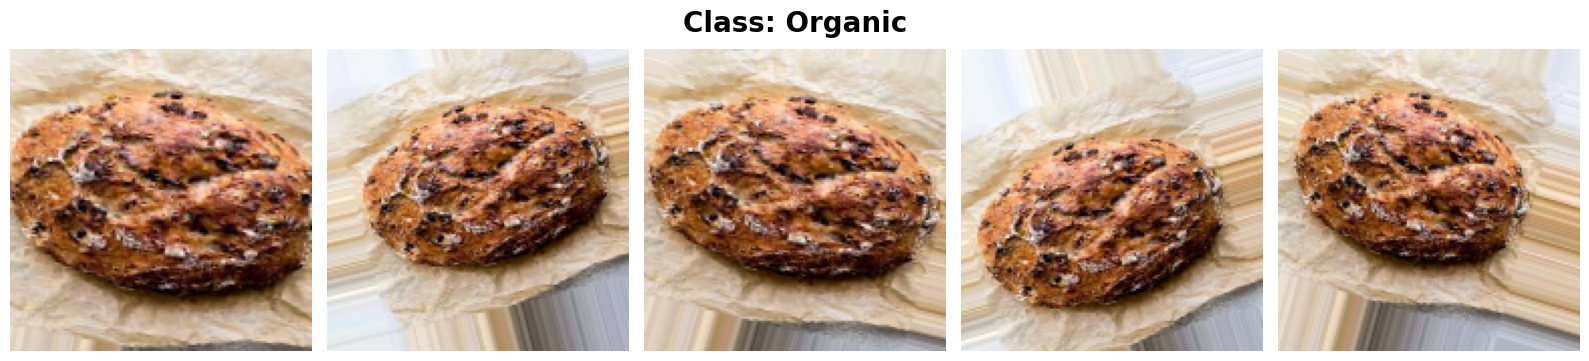

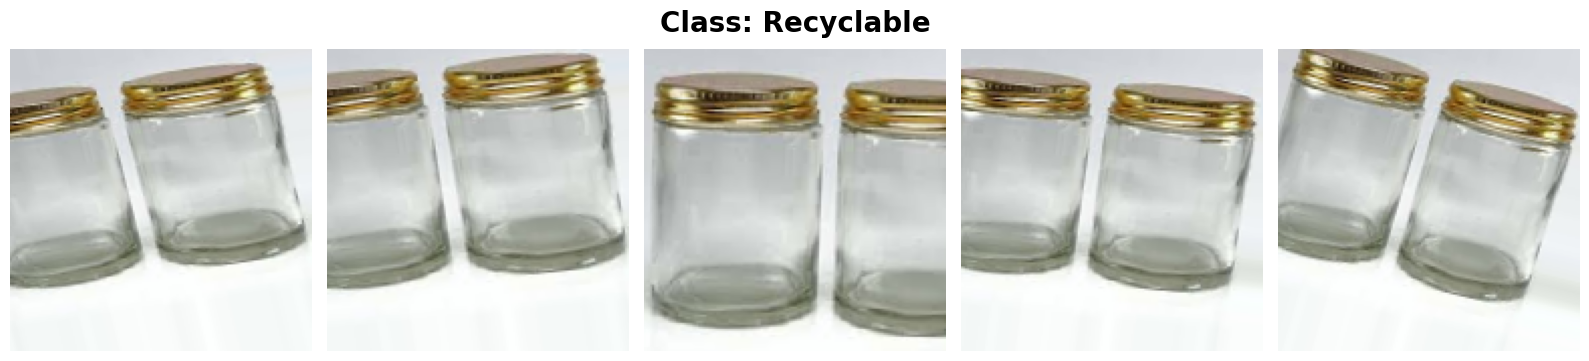

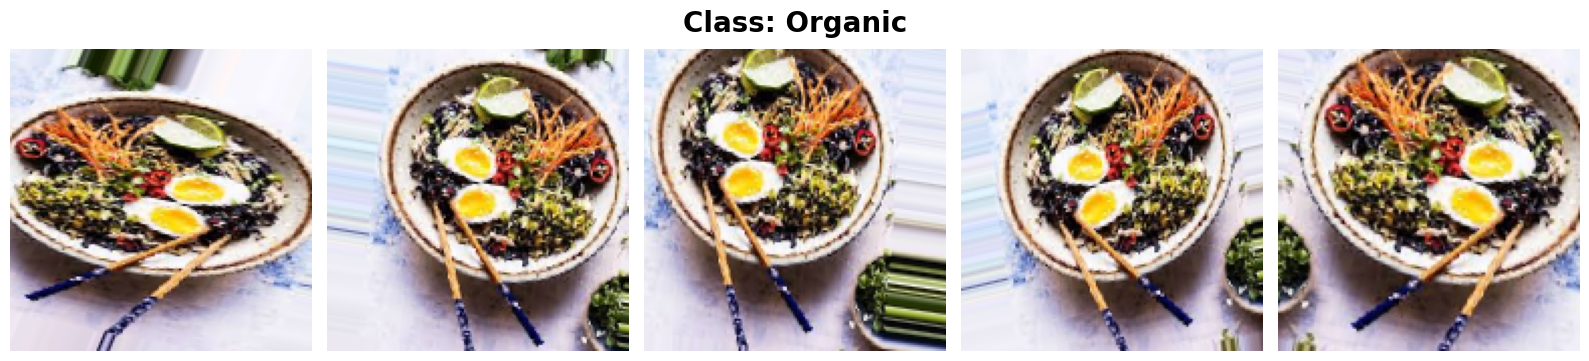

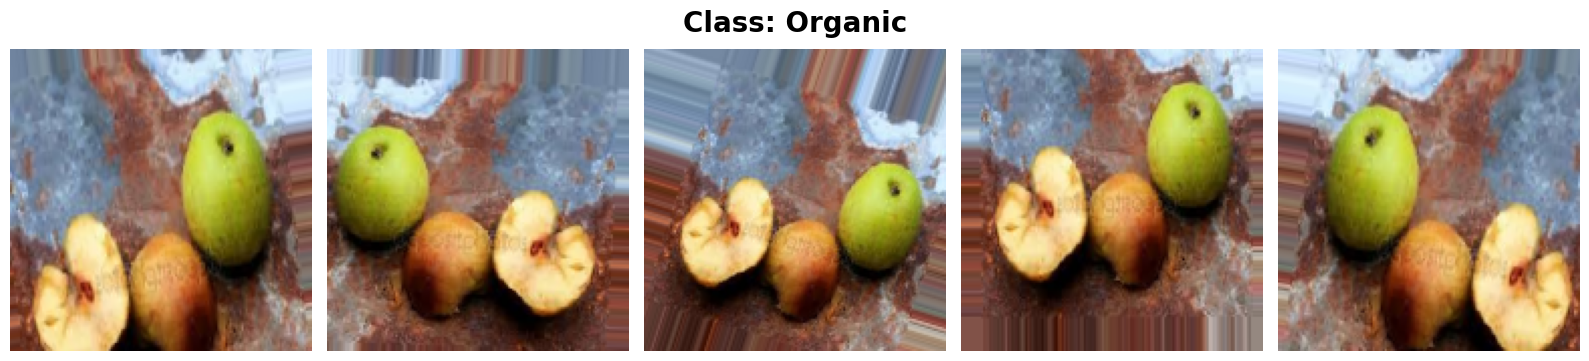

In [37]:
batch_num = [1, 3, 5, 7]
sample_num = [1, 4, 3, 2]
class_names = ['Organic', 'Recyclable']

for batch, sample in zip(batch_num, sample_num): # Changed this line
    fig, ax = plt.subplots(1, 5, figsize=(16, 6))
    class_label_index = int(train_generator[batch - 1][1][sample - 1])
    class_label = class_names[class_label_index]
    fig.suptitle(f'Class: {class_label}', fontsize=20, fontweight='bold')
    for i in range(0, 5):
        image = train_generator[batch - 1][0][sample - 1]
        ax[i].imshow(image)
        ax[i].axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=1.3)
    plt.show()

## <a id="S3"></a> 3. Build Model

### Pre-trained VGG-16 model

Let's start by loading the pre-trained VGG16 model. VGG16 is a convolutional neural network architecture pre-trained on the ImageNet dataset, a large and diverse collection of images. By leveraging transfer learning, we can utilise the features learned by VGG16 to efficiently train our waste classification model, even with a relatively smaller dataset

We will exclude the dense top layers (`include_top = False`), freeze the VGG16 layers to retain pre-trained weights, and add custom layers to adapt it to the waste classification task. 

In [7]:
# Load VGG16 with pre-trained weights
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

# Flatten the output of the VGG16 model
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

# Freeze the base model layers
for layer in basemodel.layers: 
    layer.trainable = False

Freezing the VGG16 layers prevents their weights from being updated during the initial training phase. This allows the model to focus on learning the optimal weights for the custom top layers, while preserving the valuable feature extraction capabilities of VGG16.

### Custom top layers

We use dense layers with regularisation (Dropout) and normalisation (BatchNormalization) to enhance learning.

Dense layers are fully connected layers that learn high-level representations of the image features. Batch Normalization helps to stabilise training and improve convergence. Dropout is a regularisation technique that prevents overfitting by randomly dropping out neurons during training.

In [8]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,176,769 (73.15 MB)

 Trainable params: 4,460,033 (17.01 MB)

 Non-trainable params: 14,716,736 (56.14 MB)

In [9]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.RMSprop(learning_rate=1e-4),
    metrics = ['accuracy']
)

## <a id="S4"></a> 4. Train the Model 

### Early stopping

Early Stopping is a technique that monitors the model's performance on the validation set and stops training when the validation loss starts to increase. This prevents overfitting, where the model learns the training data too well and performs poorly on unseen data.

In [10]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4, mode = 'min', min_delta=0.01)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Learning rate scheduling

Learning rate scheduling is a technique that adjusts the learning rate during training. This can help the model converge faster and find a better solution. We will test two different schedulers:

- `exp_decay`: reduces learning rate exponentially
- `ReduceLROnPlateau`: reduces learning rate when validation loss plateaus, allowing better optimization

In [11]:
# def exp_decay(epoch):
#     initial_lrate = 1e-4
#     k = 0.1
#     lrate = initial_lrate * np.exp(-k*epoch)
#     return lrate

# lr_scheduler = LearningRateScheduler(exp_decay)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

### Loss history log

In [12]:
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        
loss_history = LossHistory_()

### Model checkpoint

Model Checkpointing saves the model's weights at the epoch with the best validation performance. This ensures that we can later load the best-performing model, even if training continues for additional epochs.

In [13]:
checkpoint_path='waste_classification_checkpoint.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

### Fit and train

In [14]:
callbacks_list_ = [early_stopping, lr_scheduler, loss_history, model_checkpoint]

n_epochs = 10
train_steps= train_generator.samples // batch_size
val_steps = val_generator.samples // batch_size

history = model.fit(train_generator, 
                    steps_per_epoch=train_steps, 
                    epochs=n_epochs,
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    callbacks = callbacks_list_,
                    verbose=1
                   )

Epoch 1/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 2655s 5s/step - accuracy: 0.8066 - loss: 0.4694 - val_accuracy: 0.8515 - val_loss: 0.3991 - learning_rate: 1.0000e-04
Epoch 2/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 114s 202ms/step - accuracy: 0.7812 - loss: 0.4736 - val_accuracy: 0.8528 - val_loss: 0.3978 - learning_rate: 1.0000e-04
Epoch 3/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 585s 1s/step - accuracy: 0.8664 - loss: 0.3358 - val_accuracy: 0.8799 - val_loss: 0.3202 - learning_rate: 1.0000e-04
Epoch 4/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 116s 204ms/step - accuracy: 0.8750 - loss: 0.2256 - val_accuracy: 0.8797 - val_loss: 0.3210 - learning_rate: 1.0000e-04
Epoch 5/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 585s 1s/step - accuracy: 0.8726 - loss: 0.3198 - val_accuracy: 0.8823 - val_loss: 0.3021 - learning_rate: 1.0000e-04
Epoch 6/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 114s 200ms/step - accuracy: 0.8750 - loss: 0.2991 - val_accuracy: 0.8859 - val_loss: 0.2986 - learning_rate: 1.0000e-04
Epoch 7/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 579s 1s/

## <a id="S5"></a> 5. Fine-tune the Model

Fine-tuning involves unfreezing some of the top layers of the pre-trained VGG16 model and training them along with the custom top layers. This allows the model to adapt the learned features to the specific characteristics of the waste classification task, potentially improving performance.

In [16]:
# Clone the model before fine-tuning
model_finetuned = tf.keras.models.clone_model(model)
model_finetuned.set_weights(model.get_weights()) #copy the weights

checkpoint_path='waste_classification_finetuned_checkpoint.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
callbacks_list_ = [early_stopping, lr_scheduler, loss_history, model_checkpoint]

### Unfreeze top layers of the pre-trained VGG16 model

We will unfreeze only some of the top layers (starting from block5_conv3) because these layers are responsible for learning higher-level features that are more specific to the image content. Lower layers learn more general features (e.g., edges, colors) that are often useful across different tasks.

Additionally, a lower learning rate (1e-5 vs 1e-4) will be used during fine-tuning to avoid disrupting the pre-trained weights too much. This allows the model to make gradual adjustments to the learned features, rather than drastically changing them.

In [17]:
basemodel_finetuned=model_finetuned.layers[0]

print('\n\033[1mBefore unfreezing top layers:\n\033[0m')
for layer in basemodel_finetuned.layers:
    print(f"{layer.name}: {layer.trainable}")

#Unfreeze all layers after block5_conv3
set_trainable = False

for layer in basemodel_finetuned.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print('\n\033[1mAfter unfreezing top layers:\n\033[0m')
for layer in basemodel_finetuned.layers:
    print(f"{layer.name}: {layer.trainable}")
    
# Re-compile the model
model_finetuned.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])
model_finetuned.summary()


Before unfreezing top layers:

input_layer: True
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: False
block5_pool: False
flatten: False

After unfreezing top layers:

input_layer: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten: True


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,176,769 (73.15 MB)

 Trainable params: 6,819,841 (26.02 MB)

 Non-trainable params: 12,356,928 (47.14 MB)

### Fit and train

In [18]:
# Continue training 
history_finetuned = model_finetuned.fit(train_generator, 
                              steps_per_epoch=train_steps, 
                              epochs=n_epochs,
                              validation_data=val_generator,
                              validation_steps=val_steps, 
                              callbacks = callbacks_list_, 
                              verbose=1)

Epoch 1/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - accuracy: 0.8973 - loss: 0.2599 - val_accuracy: 0.8841 - val_loss: 0.2967 - learning_rate: 1.0000e-05
Epoch 2/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 119s 210ms/step - accuracy: 0.7500 - loss: 0.7137 - val_accuracy: 0.8832 - val_loss: 0.2957 - learning_rate: 1.0000e-05
Epoch 3/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.9040 - loss: 0.2435 - val_accuracy: 0.8839 - val_loss: 0.3051 - learning_rate: 1.0000e-05
Epoch 4/10
  1/564 ━━━━━━━━━━━━━━━━━━━━ 7:59 852ms/step - accuracy: 0.9062 - loss: 0.1851
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
564/564 ━━━━━━━━━━━━━━━━━━━━ 118s 208ms/step - accuracy: 0.9062 - loss: 0.1851 - val_accuracy: 0.8839 - val_loss: 0.3039 - learning_rate: 1.0000e-05
Epoch 5/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.9066 - loss: 0.2373 - val_accuracy: 0.8812 - val_loss: 0.3069 - learning_rate: 2.0000e-06


## <a id="S6"></a> 6. Model Prediction and Evaluation

### Learning progression (training set)

#### Loss and accuracy


In [19]:
history.history['accuracy']

[0.8352477550506592,
 0.78125,
 0.8667665719985962,
 0.875,
 0.8785861134529114,
 0.875,
 0.8831363320350647,
 0.9375,
 0.8922368288040161]

In [33]:
train_loss, train_accuracy = model.evaluate(test_generator)
train_loss_finetuned, train_accuracy_finetuned = model_finetuned.evaluate(test_generator)
print(f"Train accuracy before fine-tuning: {train_accuracy:.2f}")
print(f"Train loss before fine-tuning: {train_loss:.2f}")
print(f"\nTrain accuracy after fine-tuning: {train_accuracy_finetuned:.2f}")
print(f"Train loss after fine-tuning: {train_loss_finetuned:.2f}")

Train accuracy before fine-tuning: 0.85
Train loss before fine-tuning: 0.39

Train accuracy after fine-tuning: 0.86
Train loss after fine-tuning: 0.35


The plot below shows the training and validation accuracy and loss to understand the model’s learning progress.

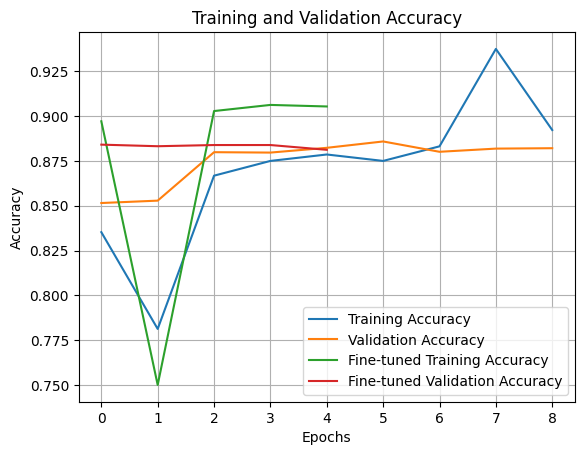

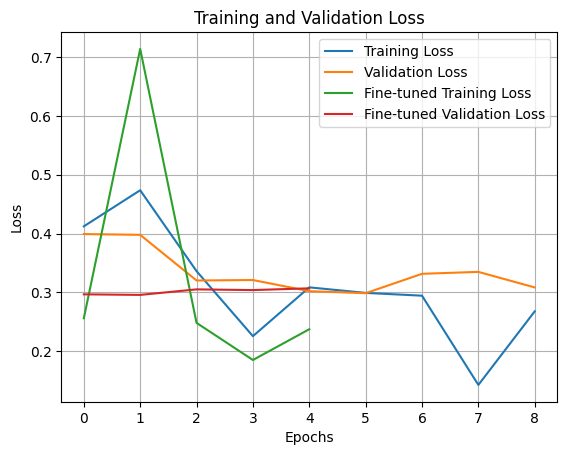

In [21]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_finetuned.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_finetuned.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_finetuned.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_finetuned.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

### Model performance (test set)

#### Predictions

In [22]:
# Get the class indices and class names from the test generator
class_names = list(test_generator.class_indices.keys())
true_classes = test_generator.classes
true_class_names = [class_names[i] for i in true_classes]

In [23]:
# Make predictions
predictions = model.predict(test_generator)
predictions_finetuned = model_finetuned.predict(test_generator)

79/79 ━━━━━━━━━━━━━━━━━━━━ 64s 813ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 819ms/step


In [24]:
# In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
predictions_classes = (predictions > 0.5).astype(int).flatten()
predictions_class_names = [class_names[i] for i in predictions_classes]

predictions_classes_finetuned = (predictions_finetuned > 0.5).astype(int).flatten()
predictions_class_names_finetuned = [class_names[i] for i in predictions_classes_finetuned]

#### Loss and accuracy

In [31]:
test_loss, test_accuracy = model.evaluate(test_generator)
test_loss_finetuned, test_accuracy_finetuned = model_finetuned.evaluate(test_generator)
print(f"Test accuracy before fine-tuning: {test_accuracy:.2f}")
print(f"Test loss before fine-tuning: {test_loss:.2f}")
print(f"\nTest accuracy after fine-tuning: {test_accuracy_finetuned:.2f}")
print(f"Test loss after fine-tuning: {test_loss_finetuned:.2f}")

Test accuracy before fine-tuning: 0.85
Test loss before fine-tuning: 0.39

Test accuracy after fine-tuning: 0.86
Test loss after fine-tuning: 0.35


#### Classification report

Accuracy measures the overall correctness of the model's predictions. However, in imbalanced datasets, accuracy can be misleading. Precision measures the proportion of correctly predicted positive cases, recall measures the proportion of actual positive cases that were correctly predicted, and the F1-score provides a balanced measure of precision and recall.

In [26]:
# Print classification report for both models
print('Before fine-tuning:')
print(classification_report(true_class_names, predictions_class_names))
print('After fine-tuning')
print(classification_report(true_class_names, predictions_class_names_finetuned))

Before fine-tuning:
              precision    recall  f1-score   support

           O       0.55      0.63      0.59      1401
           R       0.43      0.36      0.39      1112

    accuracy                           0.51      2513
   macro avg       0.49      0.49      0.49      2513
weighted avg       0.50      0.51      0.50      2513

After fine-tuning
              precision    recall  f1-score   support

           O       0.57      0.63      0.60      1401
           R       0.46      0.39      0.42      1112

    accuracy                           0.53      2513
   macro avg       0.51      0.51      0.51      2513
weighted avg       0.52      0.53      0.52      2513



#### Confusion matrix

The confusion matrix provides a detailed breakdown of the model's predictions, showing the number of true positives, true negatives, false positives, and false negatives. This helps to identify specific types of errors the model is making and understand which classes are being confused.

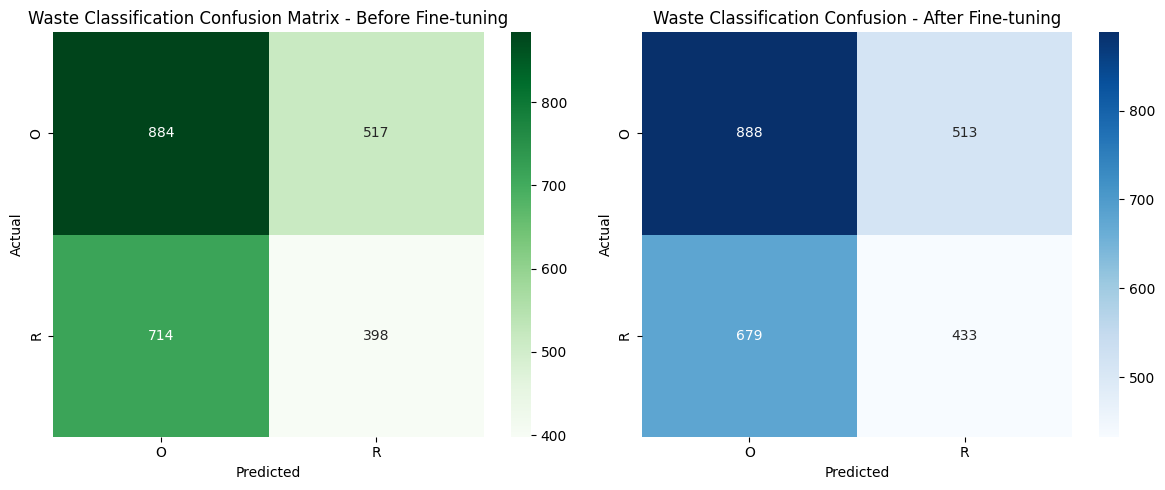

In [27]:
conf_matrix = confusion_matrix(true_class_names, predictions_class_names)
conf_matrix_finetuned = confusion_matrix(true_class_names, predictions_class_names_finetuned)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the heatmaps

sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d', ax=axes[0],xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Waste Classification Confusion Matrix - Before Fine-tuning')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_finetuned, annot=True, cmap='Blues', fmt='d', ax=axes[1],xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('Waste Classification Confusion - After Fine-tuning')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Visualise the predictions on sample images (test set)

Visualising predictions on sample images provides a qualitative assessment of the model's performance. By comparing the predicted labels with the actual labels, we can gain insights into the model's strengths and weaknesses.

In [28]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(generator, idx, true_labels, predicted_labels1, predicted_labels2):
    
    batch_num = idx // batch_size
    sample_num = idx % batch_size
    image=generator[batch_num][0][sample_num]
    
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    axes[0].imshow(image)
    axes[0].set_title(f"Model: before fine-tuning, Actual: {true_labels[idx]}, Predicted: {predicted_labels1[idx]}")
    axes[0].axis('off')
    
    axes[1].imshow(image)
    axes[1].set_title(f"Model: after fine-tuning, Actual: {true_labels[idx]}, Predicted: {predicted_labels2[idx]}")
    axes[1].axis('off')
    
    plt.show()

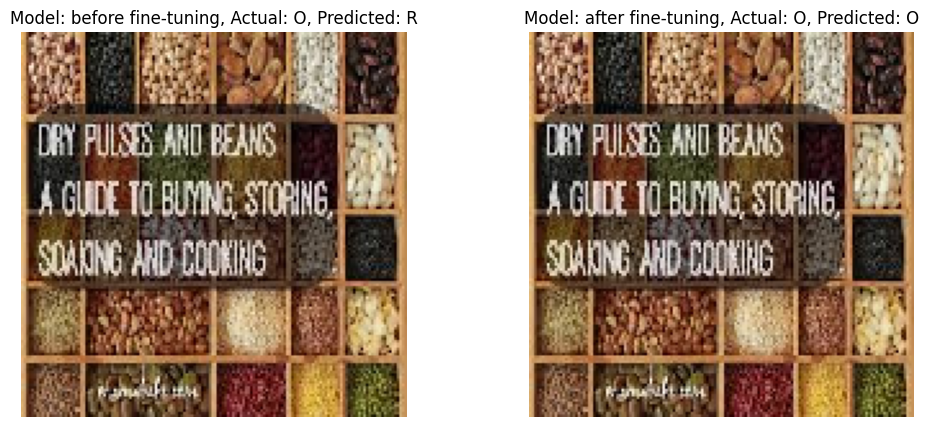

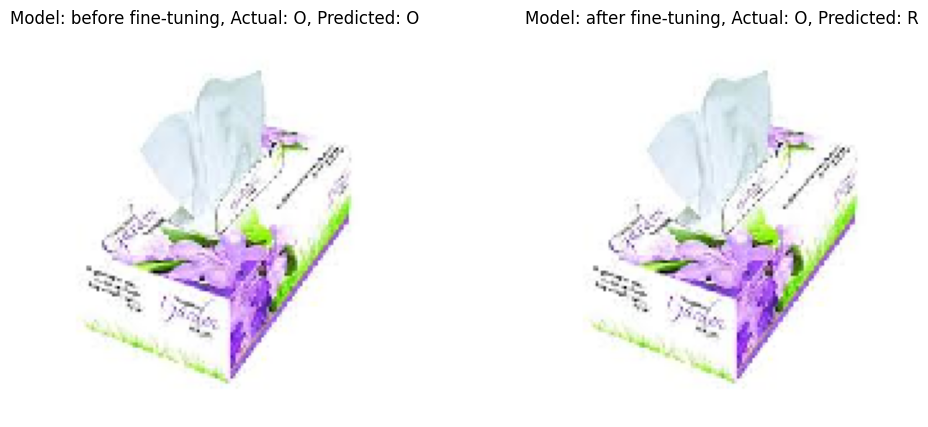

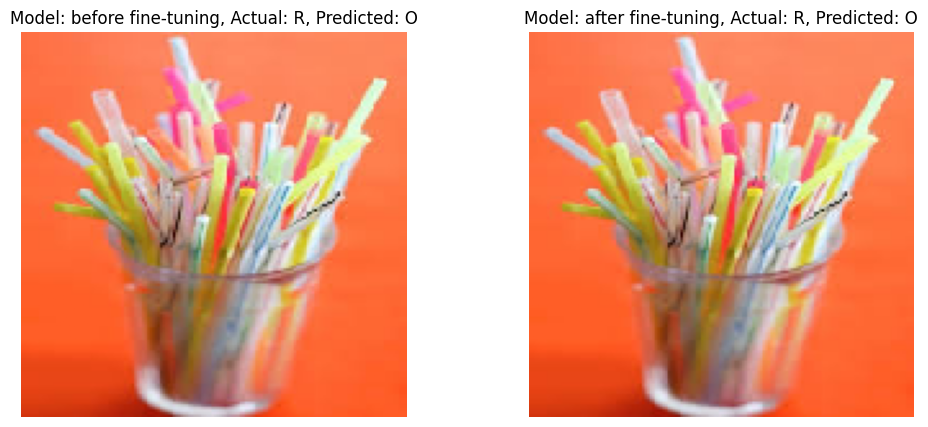

In [29]:
for i in range(3):
    index = random.randint(0, len(true_classes)-1)
    plot_image_with_title(generator = test_generator, 
                          idx = index, 
                          true_labels = true_class_names,
                          predicted_labels1 = predictions_class_names, 
                          predicted_labels2 = predictions_class_names_finetuned)